# Change-Log

2022-10-04:
- Final version. [F. Turco]

# Library Import

In [1]:
import json
import time
from datetime import timedelta
import matplotlib as mpl
# mpl.use("pgf")
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "lmodern",
    "font.serif": [],                   # blank entries should cause plots 
    "font.sans-serif": [],              # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": 11,               # LaTeX default is 10pt font.
    "font.size": 11,
    "legend.fontsize": 9,               # Make the legend/label fonts 
    "xtick.labelsize": 9,               # a little smaller
    "ytick.labelsize": 9,
    "figure.figsize": (6,4),
    "pgf.preamble": "\n".join([ # plots will use this preamble
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage{amssymb}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[]{siunitx}",
        ])
    }
mpl.rcParams.update(pgf_with_latex)
from matplotlib import pyplot as plt
plt.style.use(['science','grid'])
import matplotlib.dates as mdates
from itertools import cycle

from getPositionFromTle import GetPositionFromTle

from aerodynamics import calc_CB
from conjunction_data_message import CDM
from constants import *
from density_modelling import calc_mean_density_sgp4
from pc_calculation import *
from separation_distance import calc_separation_distance, calc_separation_distance_constrained
from get_settings import get_settings

In [2]:
settings = get_settings()

# LOADING

CDM

In [7]:
cdm_path = 'cdm_283954855.pdf'
cdm = CDM()
# cdm.load_cdm_from_pdf(cdm_path)
cdm_id = settings["CDM_ID"]
cdm.load_cdm_from_mysql(cdm_id, username=settings["username"], password=settings["password"])

print('Loaded CDM ID:\t\t\b', cdm_id)
print('TCA:\t\t\t\b', cdm.tca)

Loaded CDM ID:	 ['000042831_conj_000031457_2022162080707_15911574241200']
TCA:		 2022-06-11 08:07:07+00:00


In [4]:
semi_major_axis_1 = R_Earth.to(u.km) + cdm.apogee[0]*u.km/(1-cdm.eccentricity[0])
semi_major_axis_2 = R_Earth.to(u.km) + cdm.apogee[1]*u.km/(1-cdm.eccentricity[1])
semi_major_axis = semi_major_axis_1

gpfTLE = GetPositionFromTle(tle_file_path=settings["TLE_file_path"], maximum_tle_age = timedelta(days=365*6))

# NO MANOEUVRE SITUATION

In [5]:
R1 = np.sqrt(cdm.area_pc[0]/np.pi)
R2 = np.sqrt(cdm.area_pc[1]/np.pi)
R = R1 + R2
print("Collision probability for NO MANOEUVRE:")
try: print('Pc from CDM:\t\t{:.3e}'.format(cdm.collision_prob))
except: print('Pc from CDM:\t\t{:.3e}'.format(cdm.collision_prob[0]))
pc_CDM_foster, C_B, delta_r_B, tca = calculate_pc_foster(   x1=cdm.position_XYZ[:,0]*u.km, v1=cdm.position_dot_XYZ[:,0]*u.km/u.s, R1=R1*u.m, C1=cdm.RTN_covariance[:,:,0]*u.m**2,
                                                            x2=cdm.position_XYZ[:,1]*u.km, v2=cdm.position_dot_XYZ[:,1]*u.km/u.s, R2=R2*u.m, C2=cdm.RTN_covariance[:,:,1]*u.m**2,
                                                            epoch = cdm.tca)
print('Pc_foster:\t\t{:.3e}'.format(pc_CDM_foster))
pcmax_CDM, k = calculate_pc_max(   x1=cdm.position_XYZ[:,0]*u.km, v1=cdm.position_dot_XYZ[:,0]*u.km/u.s, R1=R1*u.m, C1=cdm.RTN_covariance[:,:,0]*u.m**2,
                                    x2=cdm.position_XYZ[:,1]*u.km, v2=cdm.position_dot_XYZ[:,1]*u.km/u.s, R2=R2*u.m, C2=cdm.RTN_covariance[:,:,1]*u.m**2,
                                    epoch = cdm.tca)
print('Pc_max:\t\t\t{:.3e}'.format(pcmax_CDM))
print('k:\t\t\t{:.3e}'.format(k))
pcmax_alfano = calculate_pc_max_alfano(x1=cdm.position_XYZ[:,0]*u.km, v1=cdm.position_dot_XYZ[:,0]*u.km/u.s, R1=R1*u.m, x2=cdm.position_XYZ[:,1]*u.km, v2=cdm.position_dot_XYZ[:,1]*u.km/u.s, R2=R2*u.m)
print('Pc_max_alf:\t\t{:.3e}'.format(pcmax_alfano))
print()

Collision probability for NO MANOEUVRE:
Pc from CDM:		2.829e-04
Pc_foster:		4.470e-07
Pc_max:			4.473e-07
k:			1.018e+00
Assuming AR=inf.
Pc_max_alf:		2.590e-04



# DENSITY AVERAGING

The space weather data in /sw-data/ is already the latest.
The space weather data in /sw-data/ is already the latest.


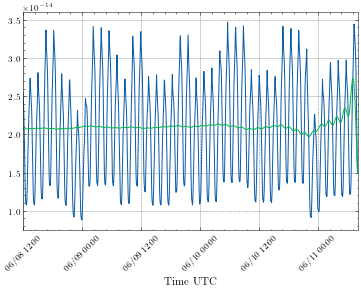

Finished density averaging.
rho_avg:			1.487e-14 kg m^-3
F_10.7:			1.032e+02
F_10.7_81daymean:	1.283e+02
Ap:			4.357e+00


In [12]:
from density_modelling import calc_mean_density_sgp4

tc = cdm.tca - cdm.creation_date
ts = np.linspace(0,tc.total_seconds(),settings["step_number"]) * u.s
dens_avg, dens, f107_avg, f107a_avg, ap_avg, alt = calc_mean_density_sgp4( start_time=cdm.creation_date,
                                                                            ts=ts, 
                                                                            model=settings["density_model"],
                                                                            TLE_folder=settings["TLE_file_path"],
                                                                            alt_output=True)
plot_time = []
for i in range(0,len(ts)):
    plot_time.append(cdm.creation_date+timedelta(seconds=ts[i].value))
fig,ax=plt.subplots(figsize=(settings["figwidth"],settings["figheight"]))
ax.plot(plot_time,dens.to(u.kg/u.m**3).value, label="Density")
ax.plot(plot_time,dens_avg[::-1].to(u.kg/u.m**3).value, label="Mean density")
ax.set_xlabel('Time UTC')
# ax.set_ylabel('$\\rho$ [\\unit{\kilogram\per\cubic\meter}]')
ax.set_xlim(plot_time[0], plot_time[len(plot_time)-1])
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
plt.show()
# fig.savefig(settings["figures_path"] + '/density.pdf')
# fig.savefig(settings["figures_path"] + '/density.pgf')

print('Finished density averaging.')
print('rho_avg:\t\t\t{:.3e} kg m^-3'.format(dens_avg[0].to(u.kg/u.m**3).value))
print('F_10.7:\t\t\t{:.3e}'.format(f107_avg))
print('F_10.7_81daymean:\t{:.3e}'.format(f107a_avg))
print('Ap:\t\t\t{:.3e}'.format(ap_avg))

# AERODYNAMIC PROPERTIES OF FLYING LAPTOP

In [13]:
CB_max, CB_nadir, CB_min = calc_CB( f107_avg, f107a_avg, ap_avg)
CB_ref = cdm.cd_am[0] * u.m**2/u.kg
print('Aerodynamic properties of Flying Laptop:')
print('CB_min:\t\t\t{:.3e} m^2 kg^-1'.format(CB_min.value))
print('CB_nadir:\t\t{:.3e} m^2 kg^-1'.format(CB_nadir.value))
print('CB_max:\t\t\t{:.3e} m^2 kg^-1'.format(CB_max.value))
print('CB_ref:\t\t\t{:.3e} m^2 kg^-1'.format(CB_ref[0].value))

Aerodynamic properties of Flying Laptop:
CB_min:			1.239e-02 m^2 kg^-1
CB_nadir:		1.346e-02 m^2 kg^-1
CB_max:			3.278e-02 m^2 kg^-1
CB_ref:			1.897e-02 m^2 kg^-1


# SEPARATION DISTANCE

In [14]:
sep_dist_max, phi, phi_dot, phi_ddot = calc_separation_distance_constrained(CB_1=CB_max,
                                                                            CB_2=CB_nadir,
                                                                            CB_ref=CB_ref,
                                                                            dens=dens_avg, 
                                                                            semi_major_axis=semi_major_axis, 
                                                                            tsteps=ts,
                                                                            t_1=timedelta(seconds=settings["t_1"]),
                                                                            t_2=timedelta(seconds=settings["t_2"]))
sep_dist_min, phi, phi_dot, phi_ddot = calc_separation_distance_constrained(CB_1=CB_min,
                                                                            CB_2=CB_nadir,
                                                                            CB_ref=CB_ref,
                                                                            dens=dens_avg, 
                                                                            semi_major_axis=semi_major_axis, 
                                                                            tsteps=ts,
                                                                            t_1=timedelta(seconds=settings["t_1"]),
                                                                            t_2=timedelta(seconds=settings["t_2"]))
    

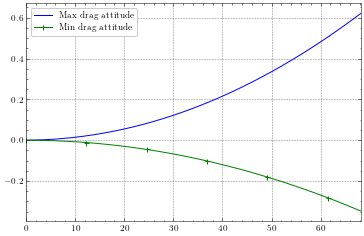

In [16]:
marker = cycle(('', '+', 'o', '*', 'v', '^', '<', '>')) 
fig,ax=plt.subplots(figsize=(settings["figwidth"],settings["figheight"]))
ax.plot(ts.value/3600, sep_dist_max.to(u.km).value, 'b',  markevery=180, marker = next(marker), ms=5, linestyle='-', label='Max drag attitude')
ax.plot(ts.value/3600, sep_dist_min.to(u.km).value, 'g',  markevery=180, marker = next(marker), ms=5, linestyle='-', label='Min drag attitude')
ax.grid(True)
# ax.set_xlabel('$t_c$ [\\unit{\hour}]')
# ax.set_ylabel('$\Delta x$ [\\unit{\kilo\meter}]')
# ax.set_title('Analytical estimation of achievable in-track separation distance')
xmin = min(ts.value/3600)
xmax = max(ts.value/3600)
ax.set_xlim(xmin, xmax) 
ax.legend()
plt.show()
# fig.savefig(settings["figures_path"] + '/sep_dist.pdf')
# fig.savefig(settings["figures_path"] + '/sep_dist.pgf')

# PARAMETER UNCERTAINTIES

In [17]:
rho = dens_avg.to(u.kg/u.m**3).value
mu_E = GM_Earth.to(u.m**3/u.s**2).value
a0 = semi_major_axis.to(u.m).value
delta_CB = CB_ref.value - CB_min.value

sigma_rho = settings["uncertainty_levels"]["rho"]*rho
sigma_a0 = settings["uncertainty_levels"]["sma"]*a0
sigma_deltaCB = settings["uncertainty_levels"]["deltaCB"]*delta_CB
sigma_ts = settings["uncertainty_levels"]["tc"]*ts.value

dx_drho = 3/2*mu_E/(a0) * delta_CB * ts.value**2
dx_da0 = -3/2*mu_E/(a0**2) * delta_CB * ts.value**2
dx_ddeltaCB = 3/2*rho*mu_E/(a0) * ts.value**2
dx_dts = 3*rho*mu_E/(a0) * delta_CB * ts.value
sigma_delta_x_min = np.sqrt((dx_drho*sigma_rho)**2+(dx_da0*sigma_a0)**2+(dx_ddeltaCB*sigma_deltaCB)**2+(dx_dts*sigma_ts)**2)

delta_CB = CB_max.value - CB_ref.value
dx_drho = 3/2*mu_E/(a0) * delta_CB * ts.value**2
dx_da0 = -3/2*mu_E/(a0**2) * delta_CB * ts.value**2
dx_ddeltaCB = 3/2*rho*mu_E/(a0) * ts.value**2
dx_dts = 3*rho*mu_E/(a0) * delta_CB * ts.value
sigma_delta_x_max = np.sqrt((dx_drho*sigma_rho)**2+(dx_da0*sigma_a0)**2+(dx_ddeltaCB*sigma_deltaCB)**2+(dx_dts*sigma_ts)**2)
print('Considering parameter uncertainties:')
print('sigma_rho:\t\t{:.3e} kg m^-3'.format(sigma_rho[-1]))
print('sigma_a0:\t\t{:.3e} m'.format(sigma_a0))
print('sigma_deltaCB:\t\t{:.3e} m^2 kg^-1'.format(sigma_deltaCB[-1]))
print('sigma_ts:\t\t{:.3e} s'.format(sigma_ts[-1]))
print('(all for maximum time)')

Considering parameter uncertainties:
sigma_rho:		0.000e+00 kg m^-3
sigma_a0:		0.000e+00 m
sigma_deltaCB:		0.000e+00 m^2 kg^-1
sigma_ts:		0.000e+00 s
(all for maximum time)


# MANOEUVRE ANALYSIS

In [18]:
pc_CDmin = np.zeros(len(sep_dist_min))
delta_r_CDmin = np.zeros(len(sep_dist_min))
pc_CDmax = np.zeros(len(sep_dist_max))
delta_r_CDmax = np.zeros(len(sep_dist_min))
C_B_CDmin = np.zeros((2,2,len(sep_dist_min)))
delta_r_B_CDmin = np.zeros((2,len(sep_dist_min)))
C_B_CDmax = np.zeros((2,2,len(sep_dist_max)))
delta_r_B_CDmax = np.zeros((2,len(sep_dist_max)))
pcmax_CDmin = np.zeros(len(sep_dist_min))
pcmax_CDmax = np.zeros(len(sep_dist_max))

for idx, sep_dist in enumerate(sep_dist_min):
    x1 = cdm.position_XYZ[:,0] + sep_dist.to(u.km).value*cdm.position_dot_XYZ[:,0]/np.linalg.norm(cdm.position_dot_XYZ[:,0])
    pc_CDmin[idx], C_B_CDmin[:,:,idx], delta_r_B_CDmin[:,idx], tca = calculate_pc_foster(   x1=x1*u.km, v1=cdm.position_dot_XYZ[:,0]*u.km/u.s, R1=R1*u.m, C1=(cdm.RTN_covariance[:,:,0]+np.diag([0,1,0])*sigma_delta_x_min[idx])*u.m**2,
                                                                                            x2=cdm.position_XYZ[:,1]*u.km, v2=cdm.position_dot_XYZ[:,1]*u.km/u.s, R2=R2*u.m, C2=cdm.RTN_covariance[:,:,1]*u.m**2,
                                                                                            epoch = cdm.tca)
    pcmax_CDmin[idx], _ = calculate_pc_max(   x1=x1*u.km, v1=cdm.position_dot_XYZ[:,0]*u.km/u.s, R1=R1*u.m, C1=(cdm.RTN_covariance[:,:,0]+np.diag([0,1,0])*sigma_delta_x_min[idx])*u.m**2,
                                                                                            x2=cdm.position_XYZ[:,1]*u.km, v2=cdm.position_dot_XYZ[:,1]*u.km/u.s, R2=R2*u.m, C2=cdm.RTN_covariance[:,:,1]*u.m**2,
                                                                                            epoch = cdm.tca)
for idx, sep_dist in enumerate(sep_dist_max):
    x1 = cdm.position_XYZ[:,0] + sep_dist.to(u.km).value*cdm.position_dot_XYZ[:,0]/np.linalg.norm(cdm.position_dot_XYZ[:,0])
    pc_CDmax[idx], C_B_CDmax[:,:,idx], delta_r_B_CDmax[:,idx], tca = calculate_pc_foster(   x1=x1*u.km, v1=cdm.position_dot_XYZ[:,0]*u.km/u.s, R1=R1*u.m, C1=(cdm.RTN_covariance[:,:,0]+np.diag([0,1,0])*sigma_delta_x_max[idx])*u.m**2,
                                                                                            x2=cdm.position_XYZ[:,1]*u.km, v2=cdm.position_dot_XYZ[:,1]*u.km/u.s, R2=R2*u.m, C2=cdm.RTN_covariance[:,:,1]*u.m**2,
                                                                                            epoch = cdm.tca)
    pcmax_CDmax[idx], _ = calculate_pc_max(   x1=x1*u.km, v1=cdm.position_dot_XYZ[:,0]*u.km/u.s, R1=R1*u.m, C1=(cdm.RTN_covariance[:,:,0]+np.diag([0,1,0])*sigma_delta_x_max[idx])*u.m**2,
                                                                                            x2=cdm.position_XYZ[:,1]*u.km, v2=cdm.position_dot_XYZ[:,1]*u.km/u.s, R2=R2*u.m, C2=cdm.RTN_covariance[:,:,1]*u.m**2,
                                                                                            epoch = cdm.tca)

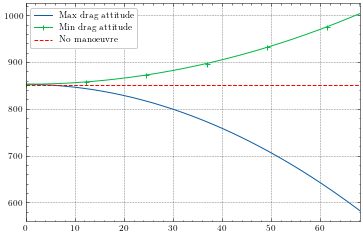

Saved plot of achievable miss distances.


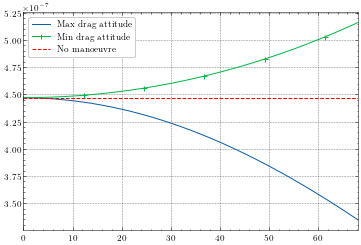

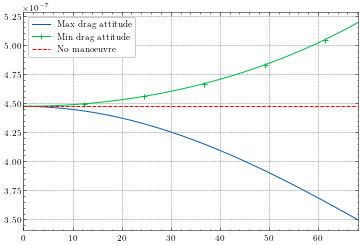

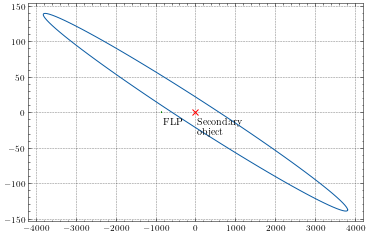

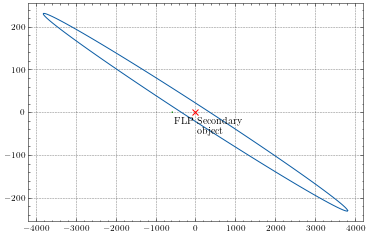

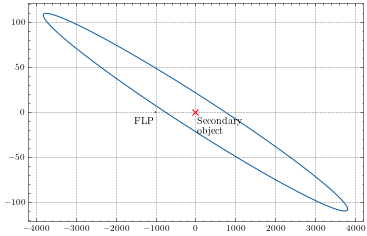

In [19]:
marker = cycle(('', '+', 'o', '*', 'v', '^', '<', '>')) 
fig,ax=plt.subplots(figsize=(settings["figwidth"],settings["figheight"]))
ax.plot(ts.value/3600, np.linalg.norm(delta_r_B_CDmax, axis=0),  markevery=180, marker = next(marker), ms=5, linestyle='-', label='Max drag attitude')
ax.plot(ts.value/3600, np.linalg.norm(delta_r_B_CDmin,axis=0),  markevery=180, marker = next(marker), ms=5, linestyle='-', label='Min drag attitude')
ax.grid(True)
# ax.set_xlabel('$t_c$ [\\unit{\hour}]')
# ax.set_ylabel('$\Delta r_{tca}$ [\\unit{\meter}]')
# ax.set_title('Distance between objects 1 and 2 depending on maneuvering time')
xmin = min(ts.value/3600)
xmax = max(ts.value/3600)
# ax.set_xticks(np.arange(xmax, xmin, -6.0))
ax.hlines(np.linalg.norm(cdm.miss_distance), xmin, xmax, linestyle='--', color='r', label='No manoeuvre')#, label='$|\Delta \mathbf{r}|$ from CDM')
ax.set_xlim(xmin, xmax) 
ax.legend()
plt.show()
# fig.savefig(settings["figures_path"] + '/miss_dist.pdf')
# fig.savefig(settings["figures_path"] + '/miss_dist.pgf')

marker = cycle(('', '+', 'o', '*', 'v', '^', '<', '>')) 
fig,ax=plt.subplots(figsize=(settings["figwidth"],settings["figheight"]))
ax.plot(ts.value/3600, pc_CDmax,  markevery=180, marker = next(marker), ms=5, linestyle='-', label='Max drag attitude')
ax.plot(ts.value/3600, pc_CDmin,  markevery=180, marker = next(marker), ms=5, linestyle='-', label='Min drag attitude')
ax.grid(True)
# ax.set_xlabel('$t_c$ [\\unit{\hour}]')
# ax.set_ylabel('$P_c$ [-]')
# ax.set_title('Probability of collision depending on flight configuration',y=1.05)
xmin = min(ts.value/3600)
xmax = max(ts.value/3600)
# ax.set_xticks(np.arange(xmax, xmin, -6.0))
ax.set_xlim(xmin, xmax) 
ax.hlines(pc_CDM_foster, xmin, xmax, linestyle='--', color='r', label='No manoeuvre')#, label='$P_c$ from CDM')
# ax.set_yscale('log')
ax.legend()
plt.show()
# fig.savefig(settings["figures_path"] + '/pc.pdf')
# fig.savefig(settings["figures_path"] + '/pc.pgf')

marker = cycle(('', '+', 'o', '*', 'v', '^', '<', '>')) 
fig,ax=plt.subplots(figsize=(settings["figwidth"],settings["figheight"]))
ax.plot(ts.value/3600, pcmax_CDmax,  markevery=180, marker = next(marker), ms=5, linestyle='-', label='Max drag attitude')
ax.plot(ts.value/3600, pcmax_CDmin,  markevery=180, marker = next(marker), ms=5, linestyle='-', label='Min drag attitude')
ax.grid(True)
# ax.set_xlabel('$t_c$ [\\unit{\hour}]')
# ax.set_ylabel('$P_{c,max}$ [-]')
# ax.set_title('Max probability of collision depending on flight configuration',y=1.05)
xmin = min(ts.value/3600)
xmax = max(ts.value/3600)
# ax.set_xticks(np.arange(xmax, xmin, -6.0))
ax.set_xlim(xmin, xmax) 
ax.hlines(pcmax_CDM, xmin, xmax, linestyle='--', color='r', label='No manoeuvre')#, label='$P_{c,max}$ from CDM')
# ax.set_yscale('log')
ax.legend()
plt.show()
# fig.savefig(settings["figures_path"] + '/pc_max.pdf')
# fig.savefig(settings["figures_path"] + '/pc_max.pgf')


fig,ax=plt.subplots(figsize=(settings["figwidth"],settings["figheight"]))
# plot position of secondary satellite
ax.scatter(0,0, color='r', marker='x')
# plot combined projected covariance
t = np.linspace(0, 2*np.pi, 100)
eigvals, eigvecs = np.linalg.eig(C_B_CDmax[:,:,0])
a,b = np.sqrt(eigvals)
z = np.array([a*np.cos(t), b*np.sin(t)])
ellipse = eigvecs @ z
ax.plot(ellipse[0,:], ellipse[1,:], label='Combined projected covariance')
# plot collision area
ax.plot(-delta_r_B_CDmax[0,0]+R*np.cos(t) , -delta_r_B_CDmax[1,0]+R*np.sin(t), label='Collision area', color='g')
# annotations
ax.annotate('Secondary\nobject', xy=(0,0), xycoords='data',
            xytext=(2, -5), textcoords='offset points',
            va='top', ha="left")
# ax.annotate('Covariance\nellipsoid', xy=(0,np.sqrt(CB[1,1])), xycoords='data',
#             xytext=(0, -16), textcoords='offset points',
#             va='top', ha="center")
ax.annotate('FLP', xy=(-delta_r_B_CDmax[0,0],-delta_r_B_CDmax[1,0]), xycoords='data',
            xytext=(2,-5), textcoords='offset points',
            va='top', ha="left")  
# descriptions etc.
# ax.set_xlabel('$x_B$ [\\unit{\\meter}]')
# ax.set_ylabel('$y_B$ [\\unit{\\meter}]')
plt.show()
# fig.savefig(settings["figures_path"] + '/conjunction_plane_noCAM.pgf')
# fig.savefig(settings["figures_path"] + '/conjunction_plane_noCAM.pdf')


fig,ax=plt.subplots(figsize=(settings["figwidth"],settings["figheight"]))
# plot position of secondary satellite
ax.scatter(0,0, color='r', marker='x')
# plot combined projected covariance
t = np.linspace(0, 2*np.pi, 100)
eigvals, eigvecs = np.linalg.eig(C_B_CDmax[:,:,-1])
a,b = np.sqrt(eigvals)
z = np.array([a*np.cos(t), b*np.sin(t)])
ellipse = eigvecs @ z
ax.plot(ellipse[0,:], ellipse[1,:], label='Combined projected covariance')
# plot collision area
ax.plot(-delta_r_B_CDmax[0,-1]+R*np.cos(t) , -delta_r_B_CDmax[1,-1]+R*np.sin(t), label='Collision area', color='g')
# annotations
ax.annotate('Secondary\nobject', xy=(0,0), xycoords='data',
            xytext=(2, -5), textcoords='offset points',
            va='top', ha="left")
# ax.annotate('Covariance\nellipsoid', xy=(0,np.sqrt(CB[1,1])), xycoords='data',
#             xytext=(0, -16), textcoords='offset points',
#             va='top', ha="center")
ax.annotate('FLP', xy=(-delta_r_B_CDmax[0,-1],-delta_r_B_CDmax[1,-1]), xycoords='data',
            xytext=(2,-5), textcoords='offset points',
            va='top', ha="left")  
# descriptions etc.
# ax.set_xlabel('$x_B$ [\\unit{\\meter}]')
# ax.set_ylabel('$y_B$ [\\unit{\\meter}]')
plt.show()
# fig.savefig(settings["figures_path"] + '/conjunction_plane_CAM_maxdrag.pgf')
# fig.savefig(settings["figures_path"] + '/conjunction_plane_CAM_maxdrag.pdf')


fig,ax=plt.subplots(figsize=(settings["figwidth"],settings["figheight"]))
# plot position of secondary satellite
ax.scatter(0,0, color='r', marker='x')
# plot combined projected covariance
t = np.linspace(0, 2*np.pi, 100)
eigvals, eigvecs = np.linalg.eig(C_B_CDmin[:,:,-1])
a,b = np.sqrt(eigvals)
z = np.array([a*np.cos(t), b*np.sin(t)])
ellipse = eigvecs @ z
ax.plot(ellipse[0,:], ellipse[1,:], label='Combined projected covariance')
# plot collision area
ax.plot(-delta_r_B_CDmin[0,-1]+R*np.cos(t) , -delta_r_B_CDmin[1,-1]+R*np.sin(t), label='Collision area', color='g')
# annotations
ax.annotate('Secondary\nobject', xy=(0,0), xycoords='data',
            xytext=(2, -5), textcoords='offset points',
            va='top', ha="left")
# ax.annotate('Covariance\nellipsoid', xy=(0,np.sqrt(CB[1,1])), xycoords='data',
#             xytext=(0, -16), textcoords='offset points',
#             va='top', ha="center")
ax.annotate('FLP', xy=(-delta_r_B_CDmin[0,-1],-delta_r_B_CDmin[1,-1]), xycoords='data',
            xytext=(-2,-5), textcoords='offset points',
            va='top', ha="right")  
# descriptions etc.
# ax.set_xlabel('$x_B$ [\\unit{\\meter}]')
# ax.set_ylabel('$y_B$ [\\unit{\\meter}]')
plt.show()
# fig.savefig(settings["figures_path"] + '/conjunction_plane_CAM_mindrag.pgf')
# fig.savefig(settings["figures_path"] + '/conjunction_plane_CAM_mindrag.pdf')